## This script makes figures using the output of motor_pipeline.ipynb

### Import Packages

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import scipy as sp
from scipy.stats import pearsonr
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind

### Define Paths and Variables

In [2]:
grp_df = pd.read_csv('grp_df_3T.csv')
diag_df = pd.read_csv('diag_df_3T.csv')

# Choose what to analyse
networks = ["SomMot", "Vis"] 
#network = "SomMot"
CESTnetworks = ["avgCEST_SomMot", "ctCEST_SomMot", "avgCEST_Vis", "ctCEST_Vis"]
CNB_scores = ["tap_tot","volt_cr", "volt_rtcr"]
CNB_valids = ["tap_valid"] 
diag_scores = ["hstatus"]
demo_scores = ["sex", "age", "race","ethnic","dateDiff"]
diag_details = ["axis1_desc1", "axis1_desc2", "axis1_desc3","axis1_desc4","axis1_desc5", "axis1_desc6"]
covariate_age = 'age' 
covariate_sex = 'sex'

In [3]:
nancount = grp_df['tap_tot'].isna().sum()
print(nancount)

43


In [20]:
# Add some values by hand from old motor glu project
grp_df.loc[grp_df['BBLID'] == 81725, grp_df.columns == 'avgCEST_SomMot'] = 9.210462
grp_df.loc[grp_df['BBLID'] == 87225, grp_df.columns == 'avgCEST_SomMot'] = 7.665792
grp_df.loc[grp_df['BBLID'] == 88608, grp_df.columns == 'avgCEST_SomMot'] = 7.385416
grp_df.loc[grp_df['BBLID'] == 90877, grp_df.columns == 'avgCEST_SomMot'] = 8.690862
grp_df.loc[grp_df['BBLID'] == 92155, grp_df.columns == 'avgCEST_SomMot'] = 8.394454


print(grp_df.loc[grp_df['BBLID'] == 92155])

Empty DataFrame
Columns: [Unnamed: 0, BBLID, Session, sex, age, race, ethnic, dateDiff, SomMot, avgCEST_SomMot, ctCEST_SomMot, tap_tot, hstatus]
Index: []


### Data Trimming

In [4]:
# Standardize groups and keep only PSD or healthy

grp_df['hstatus'] = grp_df['hstatus'].replace('NC', 'HC')
grp_df['hstatus'] = grp_df['hstatus'].replace('PROR', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('PRO', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('S', 'PSY')
grp_df['hstatus'] = grp_df['hstatus'].replace('O', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('Unknown', 'Other')
grp_df['hstatus'] = grp_df['hstatus'].replace('MDD', 'Other')

#Trim NaNs and by diagnosis; rename sex variable.
#grp_df = grp_df.dropna(subset=['avgCEST_SomMot', 'SomMot', 'hstatus']) #
#grp_df = grp_df[grp_df['hstatus'] != 'Other']
grp_df['sex'] = np.where(grp_df['sex'] == 1, 'F', 'M')

#Exclude tap-tot outliers, which are >2.5 standard deviations from the mean.
grp_df = grp_df[grp_df['BBLID'] != 94703]
grp_df = grp_df[grp_df['BBLID'] != 80557]

value_counts = grp_df['hstatus'].value_counts() 

print(value_counts)
print(grp_df)

hstatus
Other    32
PSY      29
HC       21
Name: count, dtype: int64
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff      Cont  \
0            0  117847    12564   M    NaN   NaN     NaN       NaN  0.141025   
1            1   20645    11274   F  19.84   2.0     2.0       0.0  0.312466   
2            2  128865    12165   M    NaN   NaN     NaN       NaN  0.137521   
3            3  120217    10702   M  24.77   1.0     2.0       8.0  0.222504   
4            4   21118    12258   M    NaN   NaN     NaN       NaN  0.207966   
..         ...     ...      ...  ..    ...   ...     ...       ...       ...   
86          86   90217    12064   M  24.99   1.0     2.0      48.0  0.097244   
87          87  127935  motive2   M    NaN   NaN     NaN       NaN  0.181647   
89          89   91335     9346   F  19.77   2.0     2.0     113.0  0.192194   
90          90   89095     9972   M  24.62   1.0     2.0       0.0  0.221038   
91          91   20082  motive2   M  20.28   1.0  

### Subjects Excluded:

#### Only 4 people in other group. Given reviews on meta-analysis and small "Other" sample, exclude from present analysis.
#### Exclude outliers for taptot (i.e. >2.5 sd from sample mean of 106)
#### 
#### 



### Demographics

In [5]:
# Age
age_mean_sd_all = grp_df['age'].mean(), grp_df['age'].std(), grp_df['age'].mode(), grp_df['age'].median()
age_grps = grp_df.groupby("hstatus").agg(
    Age_avg = ("age", "mean"),
    Age_std = ("age", "std"))
# Sex
sex_counts = grp_df.groupby('hstatus')['sex'].value_counts() 
total_f = sex_counts.loc(axis=0)[:, 'F'].sum()
# Tap_tot
tap_mean_sd_all = grp_df['tap_tot'].mean(), grp_df['tap_tot'].std()
tap_grps = grp_df.groupby("hstatus").agg(
    tap_avg = ("tap_tot", "mean"),
    tap_std = ("tap_tot", "std"))
# CEST
cest_mean_sd_all = grp_df['avgCEST_SomMot'].mean(), grp_df['avgCEST_SomMot'].std(), grp_df['avgCEST_SomMot'].mode(), grp_df['avgCEST_SomMot'].median()
cest_grps = grp_df.groupby("hstatus").agg(
    cest_avg = ("avgCEST_SomMot", "mean"),
    cest_std = ("avgCEST_SomMot", "std"))
# FC
fc_mean_sd_all = grp_df['SomMot'].mean(), grp_df['SomMot'].std(), grp_df['SomMot'].mode(), grp_df['SomMot'].median()
fc_grps = grp_df.groupby("hstatus").agg(
    fc_avg = ("SomMot", "mean"),
    fc_std = ("SomMot", "std"))

race_counts = grp_df.groupby('hstatus')['race'].value_counts()    


# Table 1 of manuscript should have:
# Average age (SD)
# Male/female
# Tap_tot scores
# Racial demographics
# Medications?
# Comorbidities

columns = ['Whole sample', 'PSY', 'HC']


demographics_table = pd.DataFrame({
    columns[0]: [f"{age_mean_sd_all[0]:.2f} ({age_mean_sd_all[1]:.2f})",
                 f"{total_f} ({total_f/sex_counts.sum():.2f})",
                 f"{tap_mean_sd_all[0]:.2f} ({tap_mean_sd_all[1]:.2f})",
                 f"{cest_mean_sd_all[0]:.2f} ({cest_mean_sd_all[1]:.2f})",
                 f"{fc_mean_sd_all[0]:.2f} ({fc_mean_sd_all[1]:.2f})"],
    
    columns[1]: [f"{age_grps.loc['PSY', 'Age_avg']:.2f} ({age_grps.loc['PSY', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('PSY', 'F')]} ({sex_counts.loc[('PSY', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['PSY', 'tap_avg']:.2f} ({tap_grps.loc['PSY', 'tap_std']:.2f})",
                 f"{cest_grps.loc['PSY', 'cest_avg']:.2f} ({cest_grps.loc['PSY', 'cest_std']:.2f})",
                 f"{fc_grps.loc['PSY', 'fc_avg']:.2f} ({fc_grps.loc['PSY', 'fc_std']:.2f})"],
    
    columns[2]: [f"{age_grps.loc['HC', 'Age_avg']:.2f} ({age_grps.loc['HC', 'Age_std']:.2f})",
                 f"{sex_counts.loc[('HC', 'F')]} ({sex_counts.loc[('HC', 'F')]/sex_counts.sum():.2f})",
                 f"{tap_grps.loc['HC', 'tap_avg']:.2f} ({tap_grps.loc['HC', 'tap_std']:.2f})",
                 f"{cest_grps.loc['HC', 'cest_avg']:.2f} ({cest_grps.loc['HC', 'cest_std']:.2f})",
                 f"{fc_grps.loc['HC', 'fc_avg']:.2f} ({fc_grps.loc['HC', 'fc_std']:.2f})"],
                 }, index=['Age (SD)', 'Sex (%)', 'Tapping Score avg (SD)', 'Avg SomMot GluCEST (SD)', 'Avg within-SomMot FC'])
                 
# Display the styled DataFrame
print(demographics_table)    

                          Whole sample            PSY             HC
Age (SD)                  22.85 (2.43)   22.66 (2.20)   22.88 (2.85)
Sex (%)                      23 (0.28)      13 (0.16)       9 (0.11)
Tapping Score avg (SD)   109.76 (9.25)  107.23 (9.47)  111.03 (7.00)
Avg SomMot GluCEST (SD)    7.61 (0.90)    7.37 (0.86)    7.94 (0.94)
Avg within-SomMot FC       0.52 (0.10)    0.52 (0.09)    0.54 (0.11)


### QA & Histograms

age Mean: 22.86
age Median: 23.07


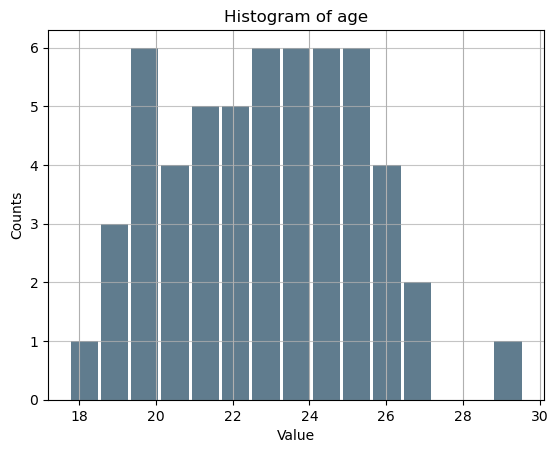

SomMot Mean: 0.53
SomMot Median: 0.53


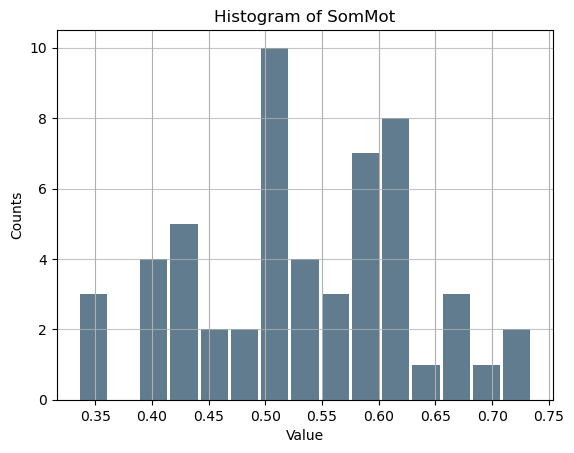

avgCEST_SomMot Mean: 7.63
avgCEST_SomMot Median: 7.68


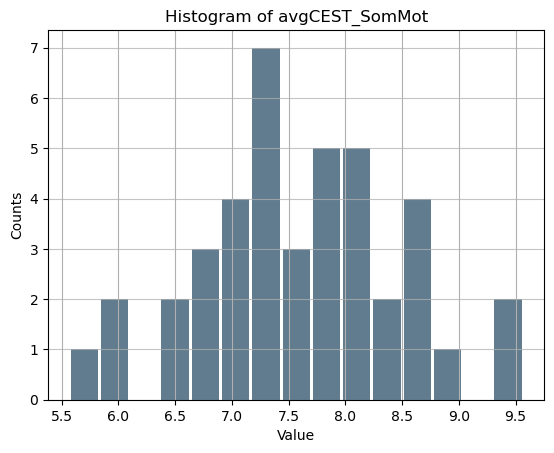

ctCEST_SomMot Mean: 631.39
ctCEST_SomMot Median: 649.00


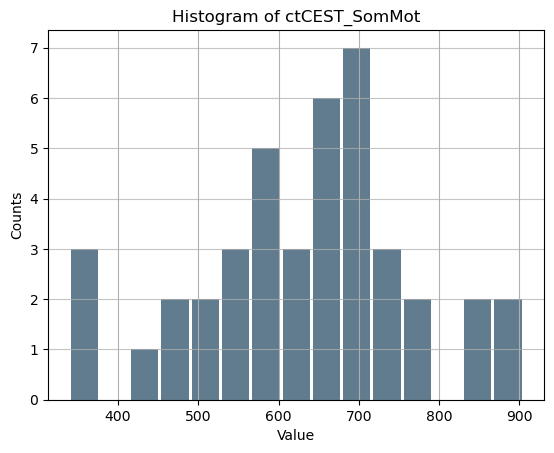

In [6]:
vars = ['age', 'SomMot', 'avgCEST_SomMot', 'ctCEST_SomMot']
for var in vars:
    # QA: Compare mean and median to see if distribution is roughly normal. Visualize mode in histograms.
    mm_df = grp_df[var].mean(), grp_df[var].median()
    print(var + " Mean: " + f"{mm_df[0]:.2f}")
    print(var + " Median: " + f"{mm_df[1]:.2f}")
    
    # Make histogram
    plt.figure()
    input = pd.Series(grp_df[var])
    input.plot.hist(grid=True, bins=15, rwidth=0.9, color='#607c8e')
    plt.title('Histogram of ' + var)
    plt.xlabel('Value')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)
    plt.show()


### Assess Demographic Variables

    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff      Cont  \
2            2  128865    12165   M    NaN   NaN     NaN       NaN  0.137521   
3            3  120217    10702   M  24.77   1.0     2.0       8.0  0.222504   
4            4   21118    12258   M    NaN   NaN     NaN       NaN  0.207966   
5            5  125511    10565   M  20.86   1.0     2.0       0.0  0.364854   
7            7  132179    10780   M  21.81   2.0     2.0       0.0  0.202675   
..         ...     ...      ...  ..    ...   ...     ...       ...       ...   
84          84   20903  motive2   M    NaN   NaN     NaN       NaN  0.217837   
86          86   90217    12064   M  24.99   1.0     2.0      48.0  0.097244   
87          87  127935  motive2   M    NaN   NaN     NaN       NaN  0.181647   
90          90   89095     9972   M  24.62   1.0     2.0       0.0  0.221038   
91          91   20082  motive2   M  20.28   1.0     2.0      18.0  0.094221   

     Default  ...  avgCEST_DorsAttn  ct

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


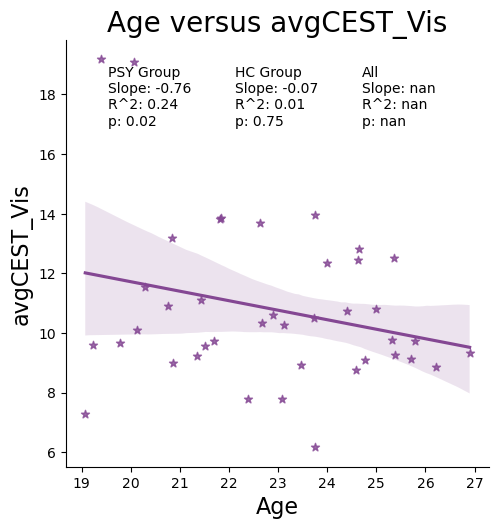

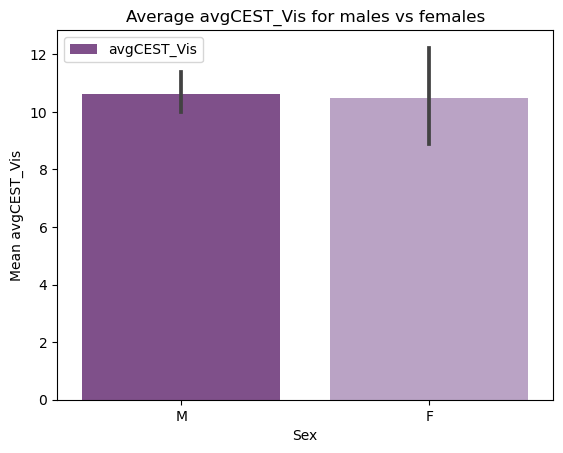

avgCEST_Vist test: t=0.16742345552322835, p=0.8675647730463143
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff      Cont  \
2            2  128865    12165   M    NaN   NaN     NaN       NaN  0.137521   
3            3  120217    10702   M  24.77   1.0     2.0       8.0  0.222504   
4            4   21118    12258   M    NaN   NaN     NaN       NaN  0.207966   
5            5  125511    10565   M  20.86   1.0     2.0       0.0  0.364854   
7            7  132179    10780   M  21.81   2.0     2.0       0.0  0.202675   
..         ...     ...      ...  ..    ...   ...     ...       ...       ...   
84          84   20903  motive2   M    NaN   NaN     NaN       NaN  0.217837   
86          86   90217    12064   M  24.99   1.0     2.0      48.0  0.097244   
87          87  127935  motive2   M    NaN   NaN     NaN       NaN  0.181647   
90          90   89095     9972   M  24.62   1.0     2.0       0.0  0.221038   
91          91   20082  motive2   M  20.28   1.0     2.0 

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


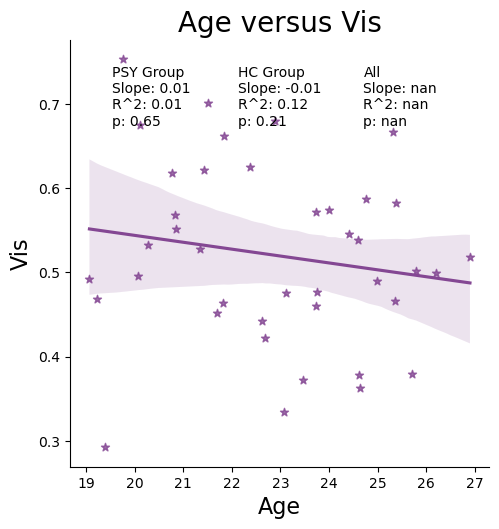

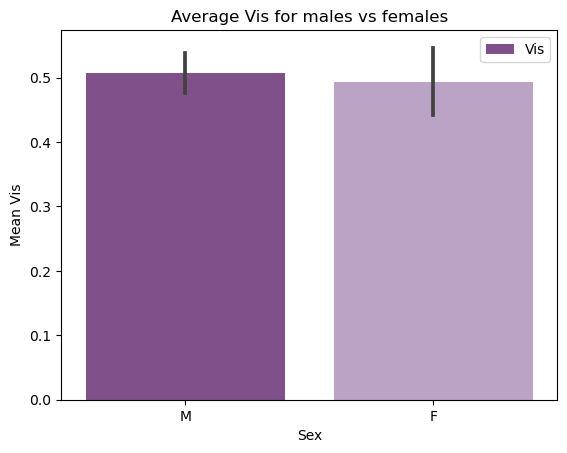

Vist test: t=0.38548335318624016, p=0.7011576391527251
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff      Cont  \
2            2  128865    12165   M    NaN   NaN     NaN       NaN  0.137521   
3            3  120217    10702   M  24.77   1.0     2.0       8.0  0.222504   
4            4   21118    12258   M    NaN   NaN     NaN       NaN  0.207966   
5            5  125511    10565   M  20.86   1.0     2.0       0.0  0.364854   
7            7  132179    10780   M  21.81   2.0     2.0       0.0  0.202675   
..         ...     ...      ...  ..    ...   ...     ...       ...       ...   
84          84   20903  motive2   M    NaN   NaN     NaN       NaN  0.217837   
86          86   90217    12064   M  24.99   1.0     2.0      48.0  0.097244   
87          87  127935  motive2   M    NaN   NaN     NaN       NaN  0.181647   
90          90   89095     9972   M  24.62   1.0     2.0       0.0  0.221038   
91          91   20082  motive2   M  20.28   1.0     2.0      18.

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


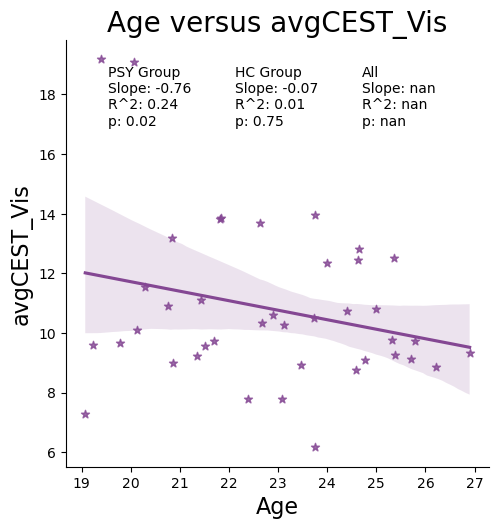

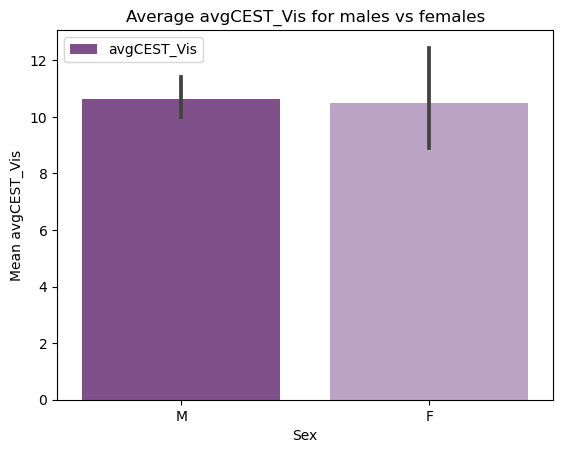

avgCEST_Vist test: t=0.16742345552322835, p=0.8675647730463143
    Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff      Cont  \
2            2  128865    12165   M    NaN   NaN     NaN       NaN  0.137521   
3            3  120217    10702   M  24.77   1.0     2.0       8.0  0.222504   
4            4   21118    12258   M    NaN   NaN     NaN       NaN  0.207966   
5            5  125511    10565   M  20.86   1.0     2.0       0.0  0.364854   
7            7  132179    10780   M  21.81   2.0     2.0       0.0  0.202675   
..         ...     ...      ...  ..    ...   ...     ...       ...       ...   
84          84   20903  motive2   M    NaN   NaN     NaN       NaN  0.217837   
86          86   90217    12064   M  24.99   1.0     2.0      48.0  0.097244   
87          87  127935  motive2   M    NaN   NaN     NaN       NaN  0.181647   
90          90   89095     9972   M  24.62   1.0     2.0       0.0  0.221038   
91          91   20082  motive2   M  20.28   1.0     2.0 

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


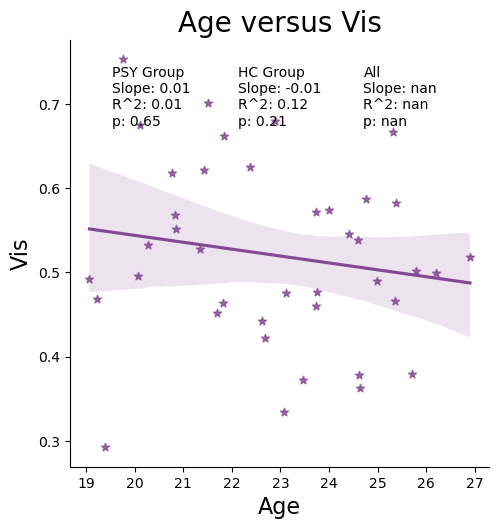

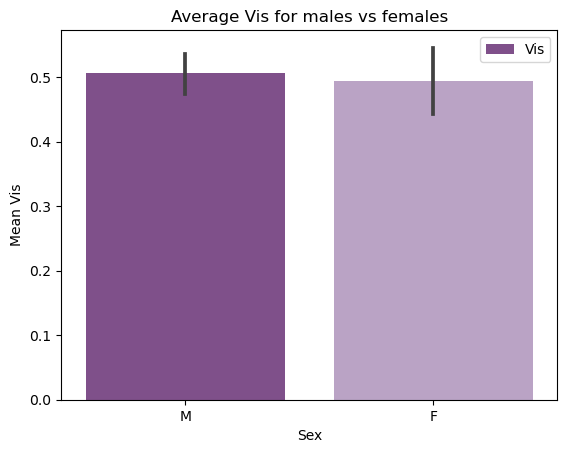

Vist test: t=0.38548335318624016, p=0.7011576391527251


In [12]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

for network in networks:
    # Quality control figures
    network="Vis"
    cestcol = "avgCEST_Vis"
    metrics = [cestcol, network]

    for metric in metrics:
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus'])
        print(graph_df)
        # Create a linear regression model for fcon
        color = colors.loc[colors['Network'] == network, 'Color'].values[0]
        sns.set_palette(color)
        plot = sns.lmplot(x='age', y=metric, data=graph_df, markers= "*") #hue='hstatus', 
        plt.xlabel("Age", fontsize=16)
        plt.ylabel(metric, fontsize=16)
        plt.title('Age versus ' + metric, fontsize = 20)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', 'age'], graph_df.loc[graph_df['hstatus'] == 'PSY', metric])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        #     # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', 'age'], graph_df.loc[graph_df['hstatus'] == 'HC', metric])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df['age'], graph_df[metric])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        plt.show() 

        # Bar plots assessing sex differences
        sns.barplot(x='sex', y=metric, data=graph_df, estimator='mean', label=metric) #yerr=avg_df[cestcol + '_std'],
        plt.xlabel('Sex')
        plt.ylabel('Mean ' + metric)
        plt.title('Average ' + metric + ' for males vs females')
        plt.legend()
        plt.show()
        t_statistic, p_value = ttest_ind(graph_df.loc[graph_df['sex'] == 'M', metric],
                                         graph_df.loc[graph_df['sex'] == 'F', metric])
        print(metric + 't test: t=' + str(t_statistic) + ', p=' + str(p_value))
    

### Main Figures

In [10]:
grp2 = grp_df
grp2.reset_index(inplace=True)
print(grp2)

    index  Unnamed: 0   BBLID  Session sex    age  race  ethnic  dateDiff  \
0       1           1   20645    11274   F  19.84   2.0     2.0       0.0   
1       3           3  120217    10702   M  24.77   1.0     2.0       8.0   
2       6           6  105176     9362   F  21.17   2.0     2.0      14.0   
3       7           7  132179    10780   M  21.81   2.0     2.0       0.0   
4       8           8   15305     8635   F  29.57   1.0     2.0     147.0   
5       9           9   17621     9270   M  22.23   2.0     2.0     544.0   
6      10          10   98831    10084   M  23.20   2.0     2.0       1.0   
7      12          12  116019    10078   M  25.72   2.0     1.0       0.0   
8      13          13   17648     8704   F  21.59   1.0     2.0     196.0   
9      14          14   96902    11870   M  20.76   1.0     1.0       6.0   
10     15          15  118864    11724   M  19.77   2.0     1.0      18.0   
11     16          16   20325    11667   M  23.07   5.0     2.0      14.0   

In [12]:
graph_df.reset_index(inplace=True)
print(graph_df)

    level_0  index  Unnamed: 0   BBLID  Session sex    age  race  ethnic  \
0         0      3           3  120217    10702   M  24.77   1.0     2.0   
1         1      6           6  105176     9362   F  21.17   2.0     2.0   
2         2      7           7  132179    10780   M  21.81   2.0     2.0   
3         3     12          12  116019    10078   M  25.72   2.0     1.0   
4         4     13          13   17648     8704   F  21.59   1.0     2.0   
5         5     16          16   20325    11667   M  23.07   5.0     2.0   
6         6     20          20   94028     PNC3   F  19.18   1.0     2.0   
7         7     21          21  125073    11756   M  26.21   2.0     2.0   
8         8     24          24   85369     PNC3   F  23.83   2.0     2.0   
9         9     25          25   93292    10306   M  25.32   2.0     2.0   
10       10     27          27  116354    11647   M  23.47   2.0     2.0   
11       11     34          34   93274    10785   M  24.64   5.0     2.0   
12       12 

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


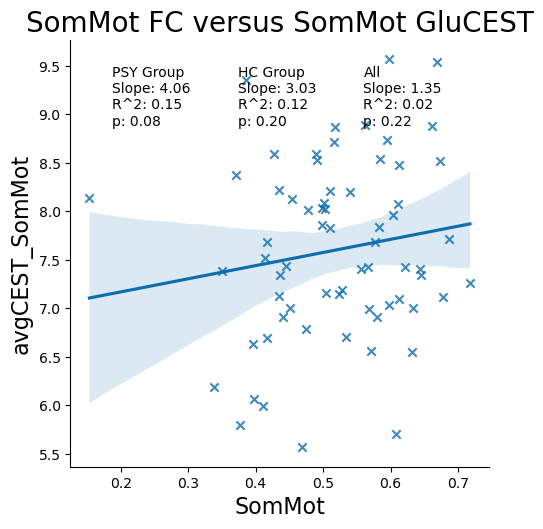

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


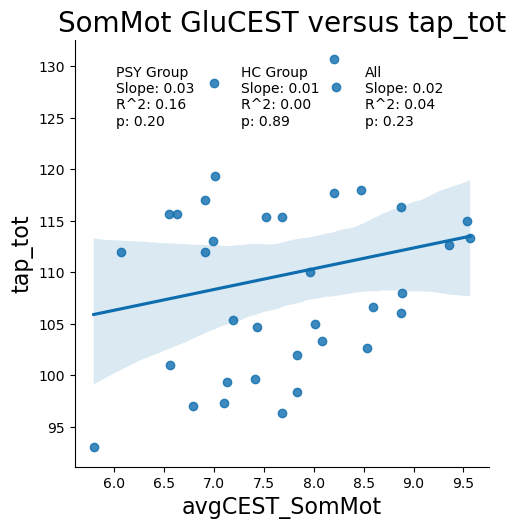

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


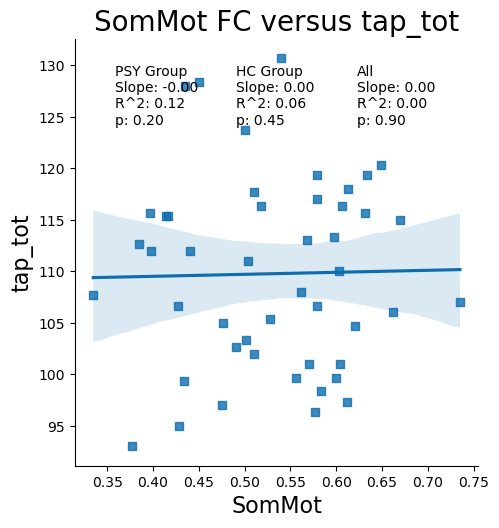

  hstatus_  avgCEST_SomMot_mean  avgCEST_SomMot_std  SomMot_mean  SomMot_std
0       HC             7.944931            0.937971     0.542425    0.108219
1    Other             7.593316            0.919707     0.511098    0.111936
2      PSY             7.369998            0.860034     0.519707    0.092083


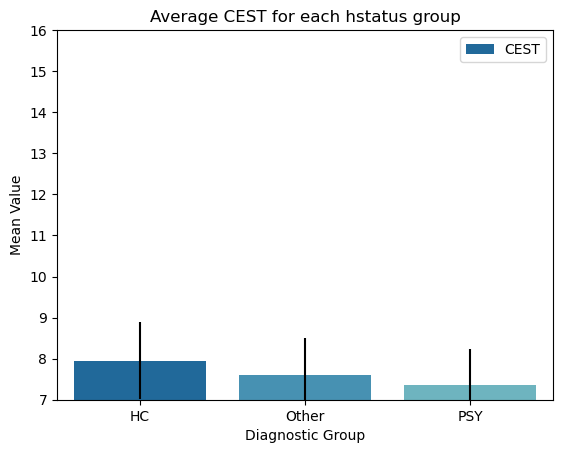

CEST t test: t=nan, p=nan


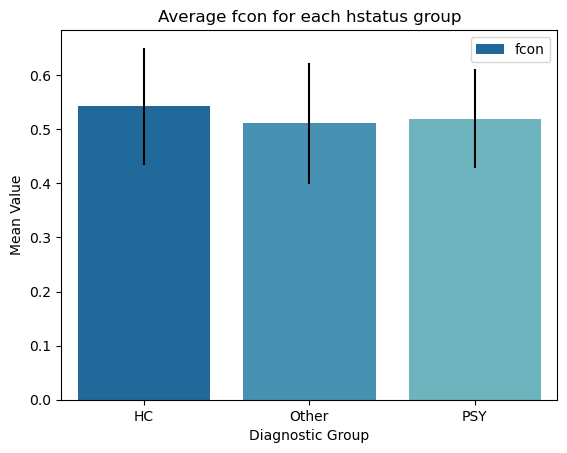

FC t test: t=-0.7998204887079191, p=0.42775543410273853


/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


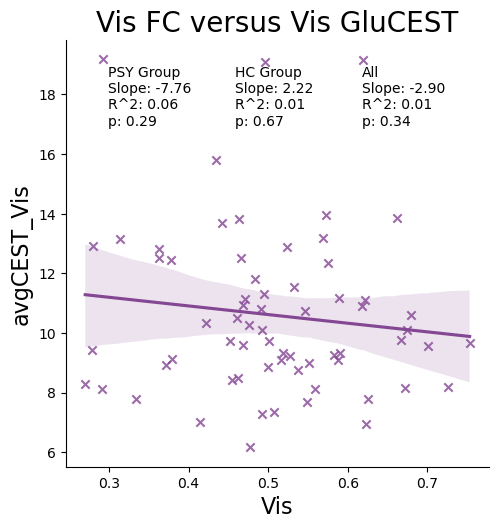

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


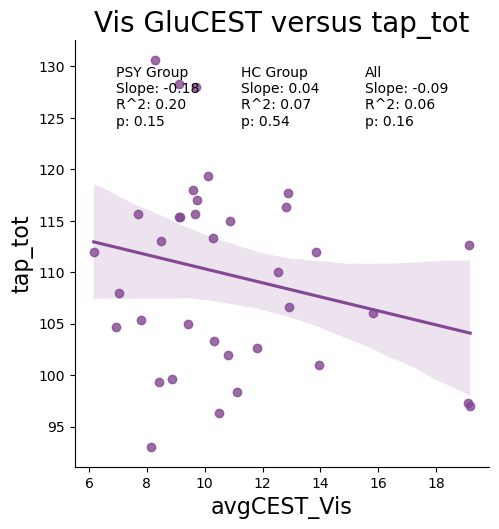

/Users/pecsok/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


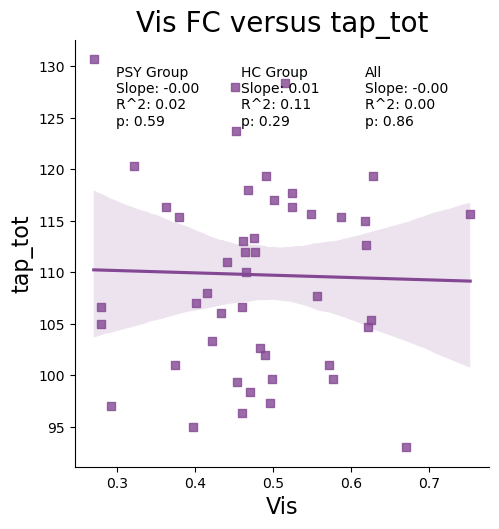

  hstatus_  avgCEST_Vis_mean  avgCEST_Vis_std  Vis_mean   Vis_std
0       HC         10.270907         1.968848  0.515689  0.109555
1    Other         10.362154         2.763167  0.491572  0.124026
2      PSY         11.185828         3.250759  0.507912  0.114262


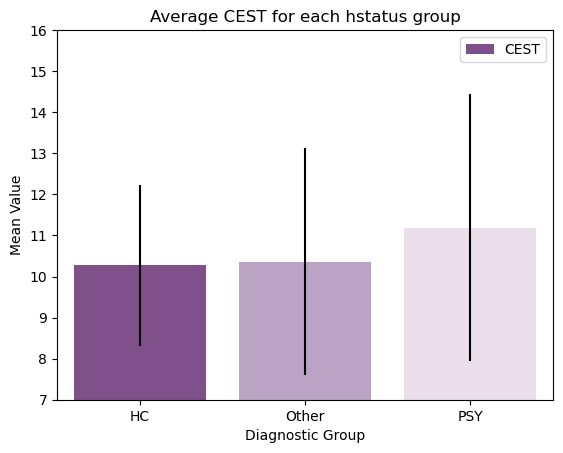

CEST t test: t=nan, p=nan


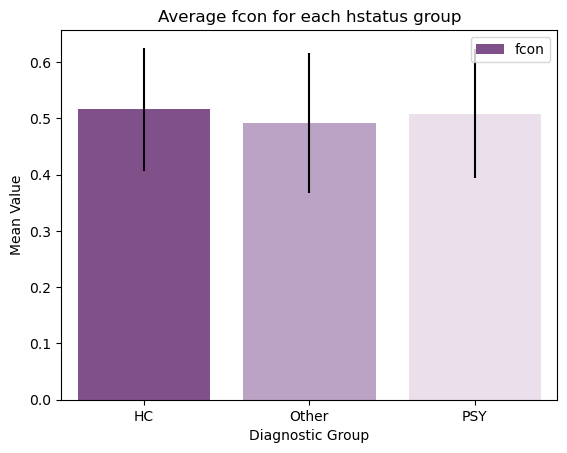

FC t test: t=-0.7998204887079191, p=0.42775543410273853


In [9]:
# Create a scatter plot with a linear regression line
for network in networks:
    cestcol = "avgCEST_" + network
    #graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[network, cestcol, 'hstatus']) #, 
    # Create a linear regression model for fcon
    color = colors.loc[colors['Network'] == network, 'Color'].values[0]
    sns.set_palette(color)
    plot = sns.lmplot(x=network, y=cestcol, data=graph_df, markers= "x") #hue='hstatus', 
    if network == "SalVentAttn":
        plt.xlabel("SN", fontsize=16)
        plt.ylabel("avgCEST_SN", fontsize=16)
        plt.title('SN FC versus SN GluCEST', fontsize = 20)
    else:
        plt.xlabel(network, fontsize=16)
        plt.ylabel(cestcol, fontsize=16)
        plt.title(network + ' FC versus ' + network + ' GluCEST' , fontsize = 20)
    # Generate and add slope, r2 and p for subset 1
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', network], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
    plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
#     # Generate and add slope, r2 and p for subset 2
    slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', network], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
    plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    # Generate and add slope, r2 and p for all data
    slope, intercept, r_value, p_value, std_err = linregress(graph_df[network], graph_df[cestcol])
    plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
    plt.show() 

    # Create CNB correlation plot for each network fcon and cest 
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, 'hstatus']) #
        # Add labels and a title to the plot
        plot = sns.lmplot(x=cestcol, y=CNB_score,data=graph_df) # hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("avgCEST_SN", fontsize=16)
            plt.title('SN GluCEST versus ' + CNB_score, fontsize = 20)
        else: 
            plt.xlabel(cestcol, fontsize=16)
            plt.title(network + ' GluCEST versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', cestcol])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', cestcol])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[cestcol])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()    

        #graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, network]) # 'hstatus'
        # Add labels and a title to the plot
        plot = sns.lmplot(x=network, y=CNB_score, data=graph_df, markers= "s") #hue='hstatus',
        if network == "SalVentAttn":
            plt.xlabel("SN", fontsize=16)
            plt.title('SN FC versus ' + CNB_score, fontsize = 20)
        else:
            plt.xlabel(network, fontsize=16)
            plt.title(network + ' FC versus ' + CNB_score, fontsize = 20)
        plt.ylabel(CNB_score, fontsize=16)
        # Generate and add slope, r2 and p for subset 1
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'PSY', CNB_score], graph_df.loc[graph_df['hstatus'] == 'PSY', network])
        plt.text(0.1, 0.8, f'PSY Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for subset 2
        slope, intercept, r_value, p_value, std_err = linregress(graph_df.loc[graph_df['hstatus'] == 'HC', CNB_score], graph_df.loc[graph_df['hstatus'] == 'HC', network])
        plt.text(0.4, 0.8, f'HC Group\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)
        # Generate and add slope, r2 and p for all data
        slope, intercept, r_value, p_value, std_err = linregress(graph_df[CNB_score], graph_df[network])
        plt.text(0.7, 0.8, f'All\nSlope: {slope:.2f}\nR^2: {r_value**2:.2f}\np: {p_value:.2f}', transform=plt.gca().transAxes)   
        # Show the plot
        plt.show()  

    # Make bar graph comparing diagnostic groups
    avg_df = grp_df.groupby('hstatus').agg({cestcol: ['mean', 'std'], network: ['mean', 'std']}).reset_index()
    # Flatten the multi-level columns
    avg_df.columns = ['_'.join(col).strip() for col in avg_df.columns.values]
    print(avg_df)

    
    # Plot CEST bar graph with error bars
    sns.barplot(x='hstatus_', y=cestcol + '_mean', data=avg_df, yerr=avg_df[cestcol + '_std'], label='CEST')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.ylim(7, 16)
    plt.title('Average CEST for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'avgCEST_SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'avgCEST_SomMot'])
    print('CEST t test: t=' + str(t_statistic) + ', p=' + str(p_value))
    # Plot fcon bar graph with error bars
    sns.barplot(x='hstatus_', y=network + '_mean', data=avg_df, yerr=avg_df[network + '_std'], label='fcon')
    plt.xlabel('Diagnostic Group')
    plt.ylabel('Mean Value')
    plt.title('Average fcon for each hstatus group')
    plt.legend()
    plt.show()
    t_statistic, p_value = ttest_ind(grp_df.loc[grp_df['hstatus'] == 'PSY', 'SomMot'],
                                     grp_df.loc[grp_df['hstatus'] == 'HC', 'SomMot'])
    print('FC t test: t=' + str(t_statistic) + ', p=' + str(p_value))


### Multiple Linear Regressions

['Unnamed: 0', 'BBLID', 'Session', 'sex', 'age', 'race', 'ethnic', 'dateDiff', 'Cont', 'Default', 'DorsAttn', 'Vis', 'SalVentAttn', 'SomMot', 'Limbic', 'avgCEST_Cont', 'ctCEST_Cont', 'avgCEST_Default', 'ctCEST_Default', 'avgCEST_SomMot', 'ctCEST_SomMot', 'avgCEST_DorsAttn', 'ctCEST_DorsAttn', 'avgCEST_Vis', 'ctCEST_Vis', 'avgCEST_Limbic', 'ctCEST_Limbic', 'avgCEST_SalVentAttn', 'ctCEST_SalVentAttn', 'tap_tot', 'hstatus']
is panda
CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.896
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.163
Time:                        11:31:43   Log-Likelihood:                -106.51
No. Observations:                  45   AIC:                     

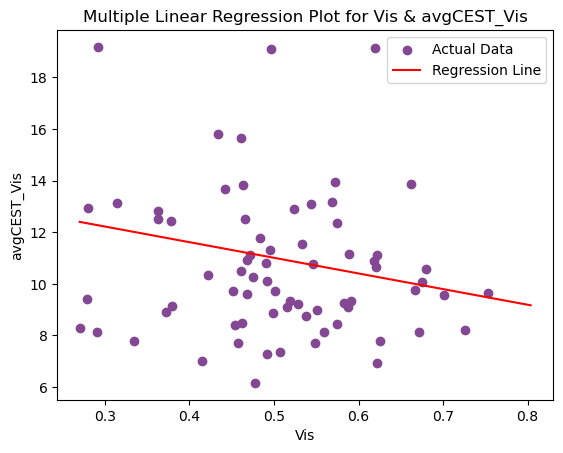

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.127
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.334
Time:                        11:31:43   Log-Likelihood:                -107.28
No. Observations:                  45   AIC:                             220.6
Df Residuals:                      42   BIC:                             226.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.9119    

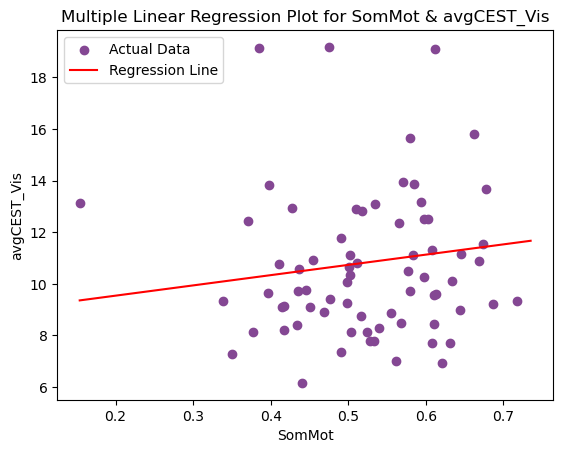

CEST-FC Association in all
                            OLS Regression Results                            
Dep. Variable:            avgCEST_Vis   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.896
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.163
Time:                        11:31:43   Log-Likelihood:                -106.51
No. Observations:                  45   AIC:                             219.0
Df Residuals:                      42   BIC:                             224.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     20.4371    

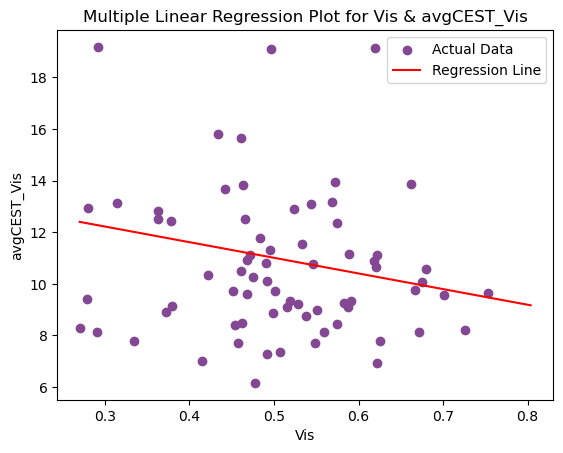

In [11]:
graph_df = grp_df
print(graph_df.columns.tolist())
print("is panda") if type(graph_df) == pd.core.frame.DataFrame else print("not panda")

cestcol='avgCEST_Vis'
network='Vis'

formula = f'{cestcol} ~ {network} + {covariate_age}'
model = smf.ols(formula=formula, data=graph_df).fit()
print('CEST-FC Association in all') 
print(model.summary())

fig, ax = plt.subplots()
ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
# Generate x values for the line
x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                       covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
# Predictions for the regression line
y_line = model.predict(x_line)
# Plot the regression line
ax.plot(x_line[network], y_line, color='red', label='Regression Line')
ax.set_xlabel(network)
ax.set_ylabel(cestcol)
ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
ax.legend()
plt.show()



for network in networks:
    formula = f'{cestcol} ~ {network} + {covariate_age}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('CEST-FC Association in all') 
    print(model.summary())

    fig, ax = plt.subplots()
    ax.scatter(graph_df[network], graph_df[cestcol], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({network: np.linspace(graph_df[network].min(), graph_df[network].max(), 100),
                           covariate_age: np.mean(graph_df[covariate_age])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[network], y_line, color='red', label='Regression Line')
    ax.set_xlabel(network)
    ax.set_ylabel(cestcol)
    ax.set_title('Multiple Linear Regression Plot for ' + network + ' & ' + cestcol)
    ax.legend()
    plt.show()
    


Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     1.681
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.204
Time:                        19:48:44   Log-Likelihood:                -112.77
No. Observations:                  32   AIC:                             231.5
Df Residuals:                      29   BIC:                             235.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

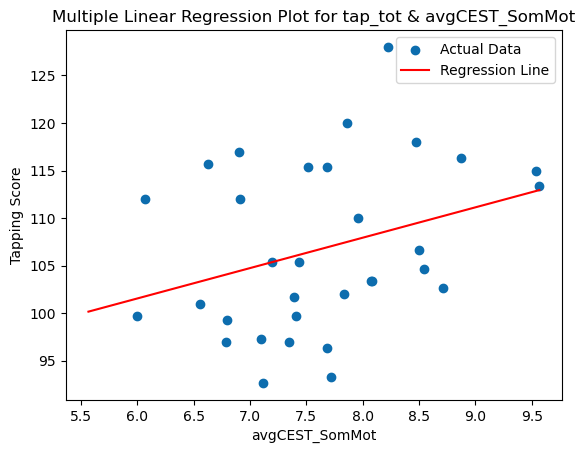

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.028
Method:                 Least Squares   F-statistic:                    0.4299
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.654
Time:                        19:48:44   Log-Likelihood:                -151.50
No. Observations:                  43   AIC:                             309.0
Df Residuals:                      40   BIC:                             314.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

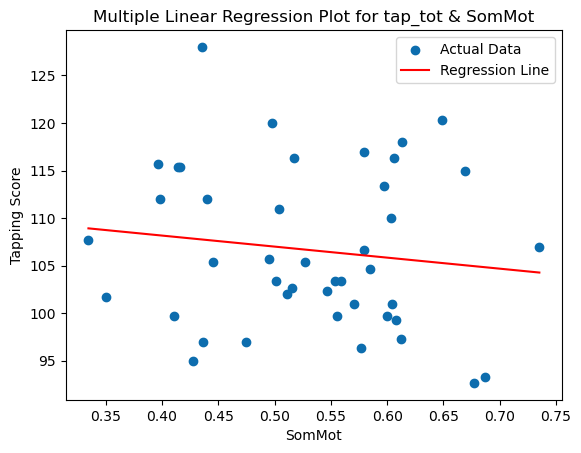

In [8]:
# First, replicate main findings of CEST and FC vs taptot using multiple linear regression to control for age and sex.p
for CNB_score in CNB_scores:
    for metric in metrics: 
        formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
        model = smf.ols(formula=formula, data=graph_df).fit()
        print('Regression of ' + metric + ' vs taptot in all') 
        print(model.summary())

        fig, ax = plt.subplots()
        ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
        # Generate x values for the line
        x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                               covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
        # Predictions for the regression line
        y_line = model.predict(x_line)
        # Plot the regression line
        ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
        ax.set_xlabel(metric)
        ax.set_ylabel('Tapping Score')
        ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
        ax.legend()
        plt.show()





Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                 -0.125
Method:                 Least Squares   F-statistic:                    0.2777
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.763
Time:                        19:48:55   Log-Likelihood:                -48.296
No. Observations:                  14   AIC:                             102.6
Df Residuals:                      11   BIC:                             104.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


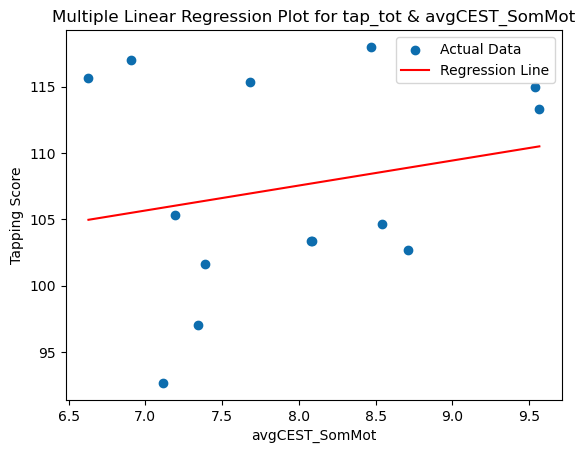

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                 -0.058
Method:                 Least Squares   F-statistic:                    0.5101
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.610
Time:                        19:48:55   Log-Likelihood:                -64.962
No. Observations:                  19   AIC:                             135.9
Df Residuals:                      16   BIC:                             138.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


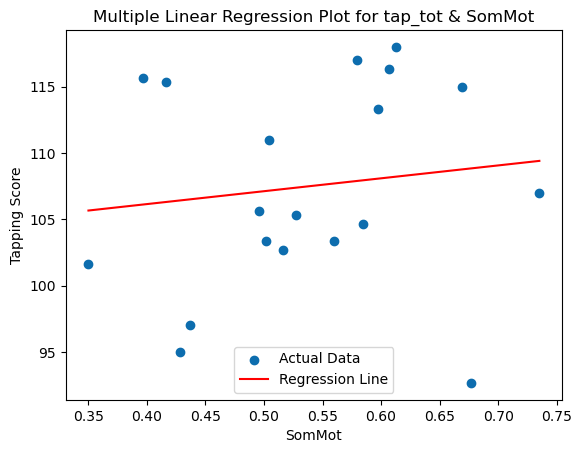

Regression of avgCEST_SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.224
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.326
Time:                        19:48:56   Log-Likelihood:                -57.584
No. Observations:                  16   AIC:                             121.2
Df Residuals:                      13   BIC:                             123.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

/Users/pecsok/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


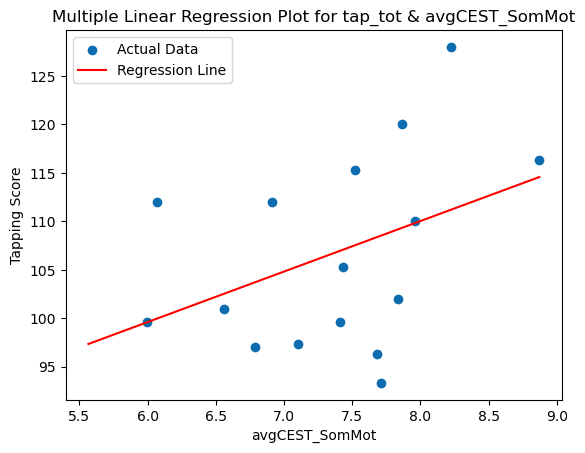

Regression of SomMot vs taptot in all
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     1.690
Date:                Sat, 23 Mar 2024   Prob (F-statistic):              0.211
Time:                        19:48:56   Log-Likelihood:                -77.772
No. Observations:                  22   AIC:                             161.5
Df Residuals:                      19   BIC:                             164.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    1

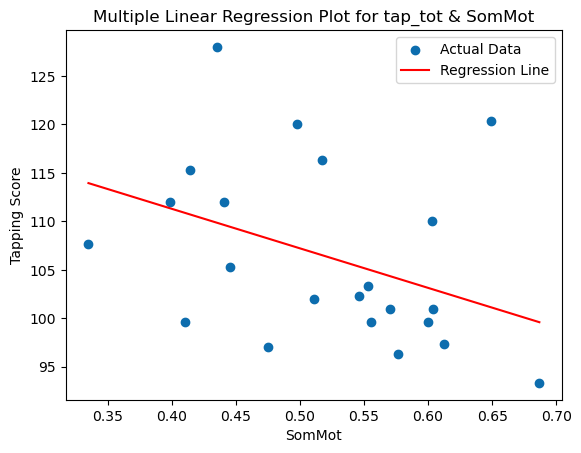

In [9]:
# Regression by hstatus of CEST and FC versus Tapping Score.
statuses = ['HC', 'PSY']
# Create a figure outside the loop to have a single plot
#fig, ax = plt.subplots()

for status in statuses:
    for metric in metrics:
        for CNB_score in CNB_scores:
            ##################################
            graph_df = grp_df[grp_df['hstatus'] == status]
            # Define formula and model
            formula = f'{CNB_score} ~ {metric} + {covariate_age}' #FIX add covariate_sex
            model = smf.ols(formula=formula, data=graph_df).fit()
            print('Regression of ' + metric + ' vs taptot in all') 
            print(model.summary())

            fig, ax = plt.subplots()
            ax.scatter(graph_df[metric], graph_df['tap_tot'], label='Actual Data')
            # Generate x values for the line
            x_line = pd.DataFrame({metric: np.linspace(graph_df[metric].min(), graph_df[metric].max(), 100),
                                   covariate_age: np.mean(graph_df[covariate_age])}) #FIX: add covariate_sex: graph_df[covariate_age] 
            # Predictions for the regression line
            y_line = model.predict(x_line)
            # Plot the regression line
            ax.plot(x_line[metric], y_line, color='red', label='Regression Line')
            ax.set_xlabel(metric)
            ax.set_ylabel('Tapping Score')
            ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + metric)
            ax.legend()
            plt.show()





Vis & tap_tot
                            OLS Regression Results                            
Dep. Variable:                tap_tot   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.263
Date:                Thu, 04 Apr 2024   Prob (F-statistic):              0.296
Time:                        11:54:52   Log-Likelihood:                -133.01
No. Observations:                  37   AIC:                             272.0
Df Residuals:                      34   BIC:                             276.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     121.4026      9.300

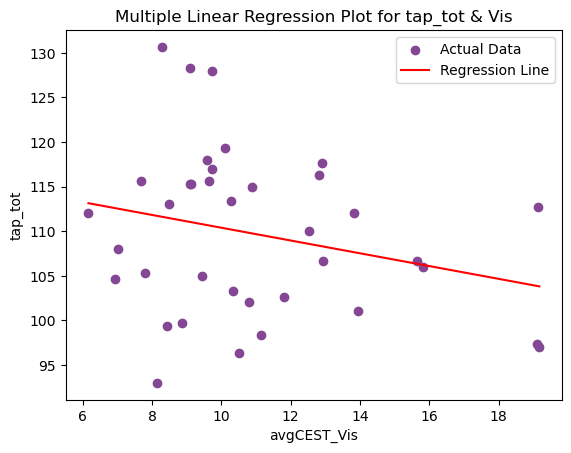

In [13]:
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Multiple linear regression predicting TapTot using SomMot and FC
#for network in networks:
    
network = "Vis"    
    
cestcol = "avgCEST_" + network
# Create a linear regression model for fcon

# Create CNB correlation plot for each network fcon and cest 
for CNB_score in CNB_scores:
 #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
    graph_df = grp_df
    graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
    graph_df = graph_df[[CNB_score, cestcol, network]]
    # Define x values and target variable
    X = graph_df[[cestcol, network]]
    Y = graph_df[CNB_score]

    ##################################
    # Define formula and model
    formula = f'{CNB_score} ~ {cestcol} + {network}'
    model = smf.ols(formula=formula, data=graph_df).fit()
    print('\n\n\n' + network + ' & ' + CNB_score) 
    print(model.summary())

    # Plotting the regression line
    fig, ax = plt.subplots()
    ax.scatter(graph_df[cestcol], graph_df[CNB_score], label='Actual Data')
    # Generate x values for the line
    x_line = pd.DataFrame({cestcol: np.linspace(graph_df[cestcol].min(), graph_df[cestcol].max(), 100),
                           network: np.mean(graph_df[network])})  # Use mean value for the network variable
    # Predictions for the regression line
    y_line = model.predict(x_line)
    # Plot the regression line
    ax.plot(x_line[cestcol], y_line, color='red', label='Regression Line')
    ax.set_xlabel(cestcol)
    ax.set_ylabel(CNB_score)
    ax.set_title('Multiple Linear Regression Plot for ' + CNB_score + ' & ' + network)
    ax.legend()
    plt.show()

### 3D Plot Troubleshooting

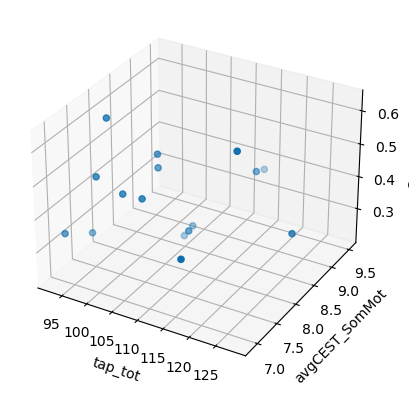

In [14]:
# BBS
colors = pd.DataFrame({'Network': ["Cont", "Default", "DorsAttn", "Vis", "SalVentAttn", "SomMot", "Limbic"],
    'Color': ['PuOr', 'PuRd_r', 'PiYG_r', 'PRGn', 'PiYG', 'GnBu_r', 'terrain_r']}) # 

# Create a scatter plot with a multiple linear regression 
for network in networks:
    cestcol = "avgCEST_" + network
    for CNB_score in CNB_scores:
     #   graph_df = grp_df[grp_df['hstatus'] != 'Other']
        graph_df = grp_df
        graph_df = graph_df.dropna(subset=[CNB_score, cestcol, network])
        graph_df = graph_df[[CNB_score, cestcol, network]]
        # Define x values and target variable
        X = graph_df[[cestcol, network]]
        Y = graph_df[CNB_score]

        ##################################
        fig = plt.figure()
        ax = fig.add_subplot(111, projection = '3d')
        ax.scatter(graph_df[CNB_score], graph_df[cestcol], graph_df[network])
        ax.set_xlabel(CNB_score)
        ax.set_ylabel(cestcol)
        ax.set_zlabel(network)
        plt.show()

In [ ]:
###Save Output

In [16]:
!jupyter nbconvert --to html motor_figures.ipynb --output motor_figures_7T.html

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook motor_figures.ipynb to html
[NbConvertApp] Writing 1602776 bytes to motor_figures_7T.html
